In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from IPython.display import clear_output

## Reading BMI data 

In [2]:
df = pd.read_csv("BMI\Data\data.csv")
df = df.iloc[:,1:]
df.head()

,bmi,gender,is_training,name
0,34.207396,Male,1,img_0.bmp
1,26.453720,Male,1,img_1.bmp
2,34.967561,Female,1,img_2.bmp
3,22.044766,Female,1,img_3.bmp
4,37.758789,Female,1,img_4.bmp


Mapping Male-Female to1 and 0

In [3]:
gender_map = {'Male': 1, 'Female': 0}
df['gender'] = df['gender'].map(gender_map)

Read images and split the data into train and test datasets

In [4]:
image_dir = 'BMI\Data\Images'  # Replace 'image_dataset/' with the actual directory containing the images


# Merge the CSV data with the image file paths
data = pd.merge(df, pd.DataFrame({'filename': os.listdir(image_dir)}), left_on='name', right_on='filename')

# Preprocess the data (e.g., handle missing values, encode gender if needed)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

Fine-tune the Pre-trained VGG16 model

In [5]:
# Define image dimensions
img_width, img_height = 224, 224

# Preprocess the images for VGG16
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

# Load VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Add a new fully connected layer for classification
x = base_model.output
# Before feeding the output of the pre-trained model into the fully connected layers, we perform Global Average Pooling
x = GlobalAveragePooling2D()(x) 
#To prevent overfitting, we added one dropout layer with a dropout of 50% into our model architecture
x = Dropout(0.5)(x)
x = Dense(64, activation='gelu')(x)  
predictions = Dense(1, activation='gelu')(x)  # 1 output for BMI prediction

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to prevent weight updates during training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [11]:
# Prepare the training and validation data
train_images = np.array([preprocess_image(os.path.join(image_dir, filename)) for filename in train_data['filename']])
train_bmi = np.array(train_data['bmi'])
train_images = train_images.reshape(-1, img_width, img_height, 3)

# Train the model
#model.fit(train_images, train_bmi, epochs=3, batch_size=32, validation_split=0.2)

In [12]:
from tensorflow.keras.models import load_model

In [13]:
model = load_model('model_BMI.h5')

In [15]:
# Prepare the test data
test_images = np.array([preprocess_image(os.path.join(image_dir, filename)) for filename in test_data['filename']])
test_images = np.squeeze(test_images, axis=1)  # Remove the extra dimension

test_bmi = np.array(test_data['bmi'])

# Make predictions on the test set
predictions = model.predict(test_images)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_bmi, predictions)
print('Mean Absolute Error:', mae)

25/25 [==============================] - 118s 5s/step
Mean Absolute Error: 7.879899992756003


Check a test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


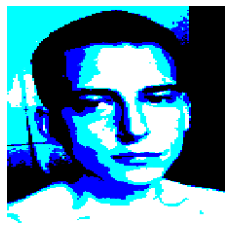

Predicted BMI: 25.25292
Actual BMI: 24.6588951901
Absolute Error: 0.5940249606568351


In [24]:
import matplotlib.pyplot as plt

image_index = 435

# Get the test image and its corresponding prediction
test_image = test_images[image_index]
prediction = predictions[image_index]

# Denormalize the image (if necessary) and display it
denormalized_image = test_image  # Replace with denormalization code if applicable
plt.imshow(denormalized_image)
plt.axis('off')
plt.show()

# Print the predicted BMI
predicted_bmi = prediction[0]
print('Predicted BMI:', predicted_bmi)

# Print the actual BMI
actual_bmi = test_bmi[image_index]
print('Actual BMI:', actual_bmi)

# Calculate and print the absolute error
absolute_error = abs(predicted_bmi - actual_bmi)
print('Absolute Error:', absolute_error)

Self test live video BMI predictor

1/1 [==============================] - 0s 96ms/step
[4.5451630e-05 1.9181794e-05 1.2715833e-05 ... 2.4831445e-05 1.5551544e-05
 1.6348191e-05]


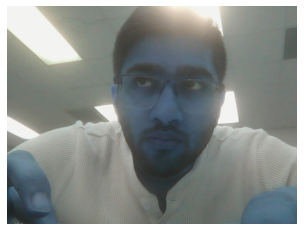

Predicted BMI =  4.545163e-05


In [23]:
cap = cv2.VideoCapture(0)  # Change the index if using a different webcam

while True:
    clear_output(wait=True)
    ret, frame = cap.read()  # Read frame from webcam
    cv2.imshow('Webcam', frame)  # Display the webcam feed
    img = frame
    # Preprocess the frame for prediction
    frame = cv2.resize(frame, (img_width, img_height))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    frame = image.img_to_array(frame)
    frame = np.expand_dims(frame, axis=0)
    frame = preprocess_input(frame)
    
    # Make a prediction on the preprocessed frame
    prediction = model.predict(frame)
    bmi = prediction[0]
    print(bmi)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        # Denormalize the image (if necessary) and display it
        denormalized_image = img  # Replace with denormalization code if applicable
        plt.imshow(denormalized_image)
        plt.axis('off')
        plt.show()
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

print("Predicted BMI = ", bmi[0])

Test without glasses

1/1 [==============================] - 0s 165ms/step
Predicted BMI=  [25.572971]


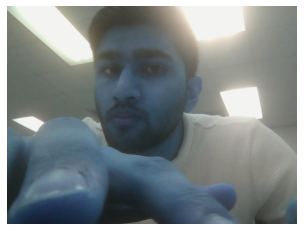

Predicted BMI =  25.572971


In [11]:
cap = cv2.VideoCapture(0)  # Change the index if using a different webcam

while True:
    clear_output(wait=True)
    ret, frame = cap.read()  # Read frame from webcam
    cv2.imshow('Webcam', frame)  # Display the webcam feed
    img = frame
    # Preprocess the frame for prediction
    frame = cv2.resize(frame, (img_width, img_height))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    frame = image.img_to_array(frame)
    frame = np.expand_dims(frame, axis=0)
    frame = preprocess_input(frame)
    
    # Make a prediction on the preprocessed frame
    prediction = model.predict(frame)
    bmi = prediction[0]
    print("Predicted BMI= ", bmi)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        # Denormalize the image (if necessary) and display it
        denormalized_image = img  # Replace with denormalization code if applicable
        plt.imshow(denormalized_image)
        plt.axis('off')
        plt.show()
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

print("Predicted BMI = ", bmi[0])

My real life BMI is aorund 24 according to online BMI calculators, so my model is close in its prediction.

Next: Using Professor's face as test image and predicting BMI.

Predicted BMI =  [26.809465]


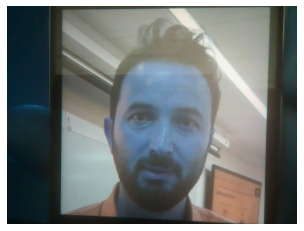

Predicted BMI =  26.809465


In [16]:
cap = cv2.VideoCapture(0)  # Change the index if using a different webcam

while True:
    clear_output(wait=True)
    ret, frame = cap.read()  # Read frame from webcam
    cv2.imshow('Webcam', frame)  # Display the webcam feed
    img = frame
    # Preprocess the frame for prediction
    frame = cv2.resize(frame, (img_width, img_height))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    frame = image.img_to_array(frame)
    frame = np.expand_dims(frame, axis=0)
    frame = preprocess_input(frame)
    
    # Make a prediction on the preprocessed frame
    prediction = model.predict(frame, verbose = 0)
    bmi = prediction[0]
    print("Predicted BMI = ", bmi)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        # Denormalize the image (if necessary) and display it
        denormalized_image = img  # Replace with denormalization code if applicable
        plt.imshow(denormalized_image)
        plt.axis('off')
        plt.show()
        break

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

print("Predicted BMI = ", bmi[0])

Predicted BMI was between 24 and 26 depending on how closethe camera was held.

In [16]:
# Example of face detection with a vggface2 model
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load the photo and extract the face
pixels = extract_face('BMI\Data\Images\img_0.bmp')
# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2)
# create a vggface model
model = VGGFace(model='resnet50')
# perform prediction
yhat = model.predict(samples)
pd.DataFrame(yhat)

1/1 [==============================] - 1s 851ms/step


,0,1,2,3,4,5,6,7,8,9,...,8621,8622,8623,8624,8625,8626,8627,8628,8629,8630
0,0.000002,0.000017,0.000263,0.000479,0.000016,0.000003,1.138926e-07,0.000014,0.000022,0.000007,...,0.000106,0.000011,0.000081,0.000005,9.330674e-07,0.000002,0.000022,0.000005,0.000018,0.000002


In [ ]:
from flask import Flask, request
import cv2
import numpy as np

In [ ]:
app = Flask(__name__)

In [ ]:
@app.route('/predict', methods=['POST'])
def predict_bmi():
    image_data = request.files['image'].read()  # Read the image data from the POST request
    image_array = np.frombuffer(image_data, np.uint8)  # Convert image data to numpy array
    frame = cv2.imdecode(image_array, cv2.IMREAD_COLOR)  # Decode the image
    
    # Preprocess the frame (e.g., resize, normalize) to match the input requirements of the model
    processed_frame = preprocess_frame(frame)
    
    # Perform inference using the model
    predicted_bmi = model.predict(processed_frame)
    
    return str(predicted_bmi)  # Return the predicted BMI as a response

In [ ]:
if __name__ == '__main__':
    app.run()

In [ ]:
from flask import Flask

app = Flask(__name__)

@app.route("/bmifinder.htlm")
def predict():
    return bmi

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     